# Airline-Satisfaction-Prediction


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df_tr = pd.read_csv('train_cleaned.csv')
df_te = pd.read_csv('test_cleaned.csv')

# drop un_named
df_tr.drop(df_tr.columns[0], axis=1, inplace=True)
df_te.drop(df_te.columns[0], axis=1, inplace=True)

In [29]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  int64  
 1   Customer Type                      103904 non-null  int64  
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  int64  
 4   Flight Distance                    103904 non-null  int64  
 5   Inflight wifi service              103904 non-null  int64  
 6   Departure/Arrival time convenient  103904 non-null  int64  
 7   Ease of Online booking             103904 non-null  int64  
 8   Gate location                      103904 non-null  int64  
 9   Food and drink                     103904 non-null  int64  
 10  Online boarding                    103904 non-null  int64  
 11  Seat comfort                       1039

In [30]:
df_tr.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,0,1,13,1,460,3,4,3,1,5,...,3,4,4,5,5,25,0,0.0,0.0,1.0
1,0,0,25,0,235,3,2,3,3,1,...,5,3,1,4,1,1,0,1.0,0.0,0.0
2,1,1,26,0,1142,2,2,2,2,5,...,3,4,4,4,5,0,1,1.0,0.0,0.0
3,1,1,25,0,562,2,5,5,5,2,...,5,3,1,4,2,11,0,1.0,0.0,0.0
4,0,1,61,0,214,3,3,3,3,4,...,4,4,3,3,3,0,1,1.0,0.0,0.0


### 

### Principal Component Analysis

It is possible for the model to overfit, with 24 features for 100k+ records and correlations between features. Diemsionality redcution can be useful to address the issue.

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# scale before pca
scaler = StandardScaler().set_output(transform="pandas")

df_tr_scaled = scaler.fit_transform(df_tr.drop('satisfaction', axis=1))

n_cps = 10
pca = PCA(n_components=n_cps)
df_tr_pca = pca.fit_transform(df_tr_scaled)
print('Top {} PCs explained {}% of the variance on training data'.format(n_cps, round(sum(pca.explained_variance_ratio_)*100 ,2) ) )

Top 10 PCs explained 77.43% of the variance on training data


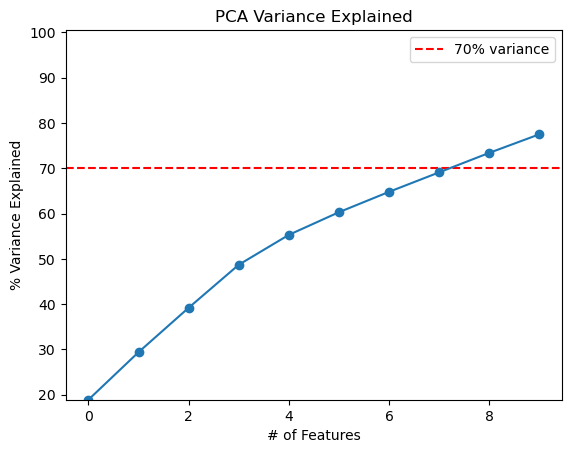

In [32]:
variance = pca.explained_variance_ratio_ #c
var=np.cumsum(np.round(variance, decimals=3)*100)

plt. ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Variance Explained' )
plt.ylim(min(var),100.5)
plt.style.context('seaborn-whitegrid')
plt.axhline(y=70, color='r', linestyle='--', label='70% variance')
plt.legend()
plt.plot(var, '-o' ,label='cumulative variance')
plt.show()

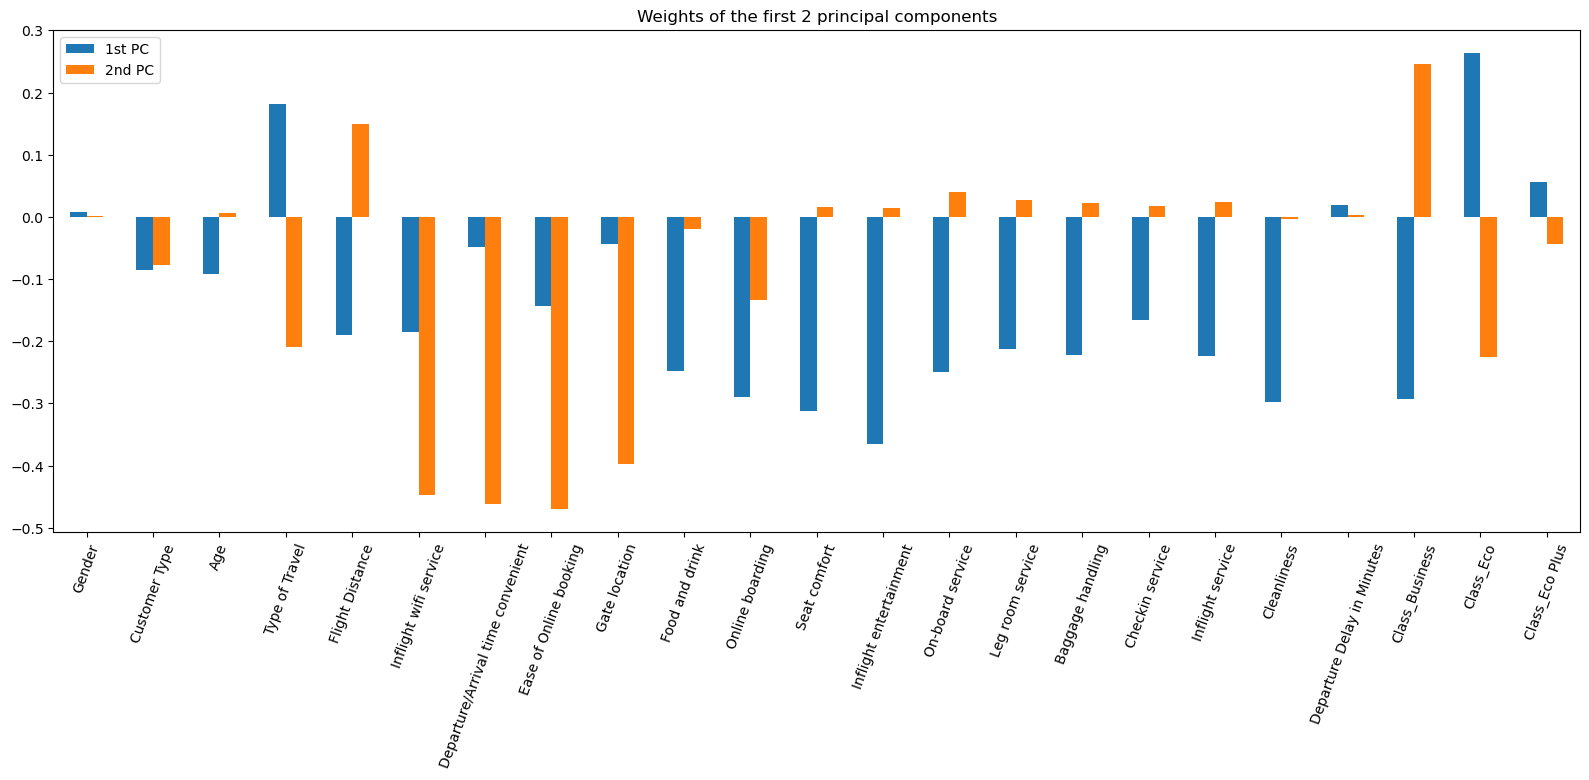

In [33]:
first_pca_component = pd.DataFrame(
    pca.components_[0], index=df_tr_scaled.columns, columns=["1st PC"])
first_pca_component["2nd PC"] =  pca.components_[1]
first_pca_component.plot.bar(
    title="Weights of the first 2 principal components", figsize=(16, 8)
)
_ = plt.tight_layout()
plt.xticks(rotation=70)
plt.show()

@xyn 你来再解释一下

1st PC: customers whose `Type of Travel` leans towards personal travel, likely not traveling on `Class_Business`, 'service quality' features such as `Seat Comfort` and `Inflight Entertainmennt` are largely negative, and travel more on `class_Eco`; -> non-business, picky, and economic

2nd PC: customers whose `Type of Travel` leans towards business travel, have longer `Flight Distance` is larger, travels more on `Class Business`, and compared with the first group they are even more picky on  'effieciency' such as `Depature/Arrival time convenient` and `xxx` -> business people who valued efficiency yet less so on leisure

In [34]:
# apply pca on test set
df_te_scaled = scaler.fit_transform(df_te.drop('satisfaction', axis=1))
df_te_pca = pca.transform(df_te_scaled)

In [35]:
# without pca
train_x = df_tr.drop('satisfaction', axis=1)
train_y = df_tr['satisfaction']
test_x =  df_te.drop('satisfaction', axis=1)
test_y =  df_te['satisfaction']

# with pca
train_x_pca = df_tr_pca
test_x_pca = df_te_pca

### Support Vector Machine

In [36]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [37]:
# without pca
clf_svm = svm.SVC().fit(train_x, train_y)

In [38]:
print('training accuracy on svm without pca: {:.2f}%'.format(accuracy_score(train_y, clf_svm.predict(train_x)) * 100))
print('testing accuracy on svm without pca: {:.2f}%'.format(accuracy_score(test_y, clf_svm.predict(test_x))* 100))

training accuracy on svm without pca: 67.07%
testing accuracy on svm without pca: 66.96%


In [39]:
# with pca
clf_svm_pca = svm.SVC(kernel='rbf').fit(train_x_pca, train_y)

In [40]:
print('training accuracy on svm with pca: {:.2f}%'.format(accuracy_score(train_y, clf_svm_pca.predict(train_x_pca)) * 100))
print('testing accuracy on svm with pca: {:.2f}%'.format(accuracy_score(test_y, clf_svm_pca.predict(test_x_pca)) * 100))

training accuracy on svm with pca: 92.38%
testing accuracy on svm with pca: 92.26%


Visualize the points on pc1 and pc2, decision boundary seems non-linear.

Which is why we used a rbf kernal to transform the data, and we need  to try non-linear methods.

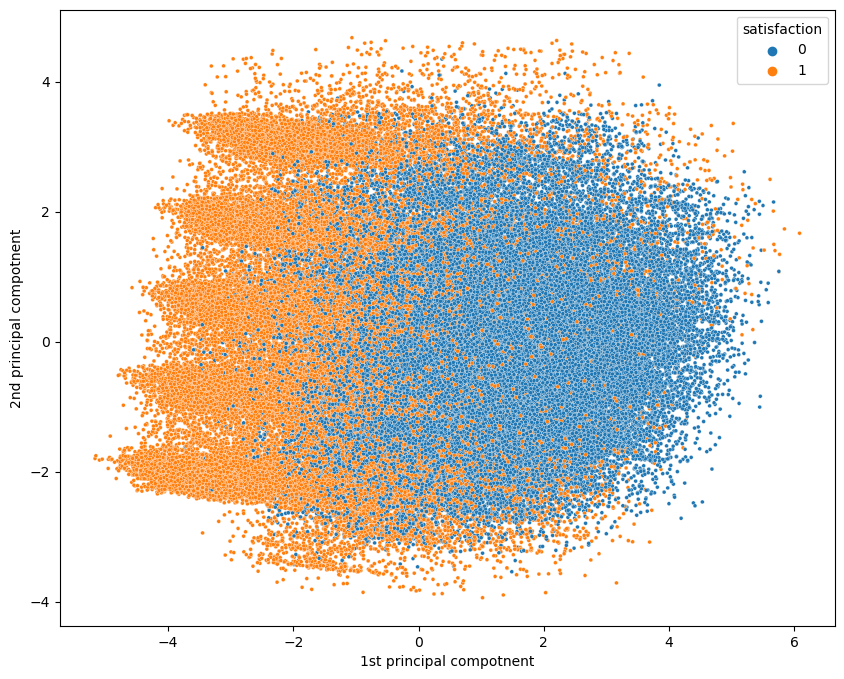

In [41]:
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=train_x_pca[:, 0], 
                y=train_x_pca[:, 1], 
                hue=train_y, 
                s=8)
plt.xlabel('1st principal compotnent')
plt.ylabel('2nd principal compotnent')
plt.show()
